# École Polytechnique de Montréal

Département Génie Informatique et Génie Logiciel
INF8460 – Traitement automatique de la langue naturelle

#### Prof. Amal Zouaq
#### Chargé de laboratoire: Félix Martel

# TP 3

## Objectifs

 - Implanter des modèles de classification neuronaux
 - Utiliser des plongements lexicaux pré-entrainés


## Travail à faire

Comme dans le TP précédent, on va travailler sur l'analyse de sentiment en utilisant les données du [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

Vous devez utiliser `scikit-learn` pour la régression logistique, et Keras pour les modèles neuronaux.

Les sections 1, 2 et 3 sont indépendantes.

Vous êtes libres d'appliquez les pré-traitements que vous jugerez utiles.

In [1]:
import glob
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re
import string
import time

from collections import Counter
from keras import Sequential
from keras.layers import Bidirectional, Dense, Embedding, LSTM
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import Sequence, to_categorical
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12478351993663249959
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6667798446
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4406045663042826119
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


### 1. Pré-traitement et lecture de données

Ici, vous devez lire vos données et appliquez les pré-traitements que vous jugerez utiles

In [3]:
DATA_TEST_POS = 0
DATA_TEST_NEG = 1
DATA_TRAIN_POS = 2
DATA_TRAIN_NEG = 3

In [5]:
def read_dataset():
    path = "./data/aclImdb"
    test_endpath = "/test"
    train_endpath = "/train"

    files_test_pos = glob.glob(path + test_endpath + "/pos/*.txt")
    files_test_neg= glob.glob(path + test_endpath + "/neg/*.txt")
    files_train_pos = glob.glob(path + train_endpath + "/pos/*.txt")
    files_train_neg = glob.glob(path + train_endpath + "/neg/*.txt")
    sections = [files_test_pos, files_test_neg, files_train_pos, files_train_neg]

    #Each data is a list of strings(reviews)
    data = [[], [], [], []]
    for i, section in enumerate(sections):
        for file in section:
            try:
                with open(file, encoding="utf8") as f:
                    data[i].append(f.read()) 

            except IOError as exc:
                if exc.errno != errno.EISDIR:
                    raise
    
    return data

In [6]:
start = time.time()
data = read_dataset()
end = time.time()

print("Données lues")
print("Temps d'exécution: " + str(end-start))

Données lues
Temps d'exécution: 129.66535997390747


Nos étapes de prétraitements sont la tokenisation, retirer les signes de ponctuations et les chiffres, convertir les mots en minuscule, retirer les stop words et garder les mots dont la longueur est superieure a 1

In [7]:
stop_words = stopwords.words('english')
tags_html = re.compile(r'<[^>]+>')

def preprocess_review(review):
    # Retirer les tags HTML
    review = tags_html.sub('', review)
    # Minuscule
    review = review.lower()
    # Retirer les signes de ponctuations et les chiffres
    review = re.sub('[^a-zA-Z]', ' ', review)
    # Tokenisation
    words = nltk.word_tokenize(review)

    pre_words = []
    for word in words:
        # Mot alphabetique, stop words et longueur de 1
        if word.isalpha() and (word not in stop_words) and len(word) > 1:
            pre_words.append(word)

    return pre_words

def clean_doc(data):
    pre_data = [[],[],[],[],[]]
    for i, dataset in enumerate(data):
        for review in dataset:
            pre_data[i].append(preprocess_review(review))
    
    return pre_data

In [8]:
start = time.time()
preprocessed_data = clean_doc(data)
end = time.time()

print("Données pré-traitées")
print("Temps d'exécution: " + str(end-start))

Données pré-traitées
Temps d'exécution: 45.12536382675171


In [9]:
def build_voc(n):
    preprocessed_data_train = preprocessed_data[DATA_TRAIN_POS] + preprocessed_data[DATA_TRAIN_NEG]

    counts = Counter(word for doc in preprocessed_data_train for word in doc)
    
    voc = {word for word, freq in counts.most_common(n)}
    
    return voc

In [10]:
train_corpus = data[DATA_TRAIN_POS] + data[DATA_TRAIN_NEG]
preprocessed_train_corpus = preprocessed_data[DATA_TRAIN_POS] + preprocessed_data[DATA_TRAIN_NEG]
Y = np.concatenate((np.ones(len(data[DATA_TRAIN_POS])), np.zeros(len(data[DATA_TRAIN_NEG]))))

### 2. Multi-layer Perceptron

**a)** Ici, on vous demande d'entraîner un perceptron multi-couches sur la matrice TF-IDF. Avant l'entraînement, affichez la structure du modèle avec `model.summary()`. Précisez la structure du réseau de neurones (taille et nombre de couches) et les paramètres d'entraînement (optimiseur, nombre d'époques, etc.).

In [11]:
MLP_VOCABULARY_LEN = 5000

In [12]:
from keras.callbacks import EarlyStopping

# EarlyStopping callback
earlyStoppingCallback = EarlyStopping(monitor='val_accuracy', mode='max', patience=3)

In [13]:
# Construire le vocabulaire de 5000 unigrammes
voc = build_voc(MLP_VOCABULARY_LEN)

# Creer la matrice Tf-idf avec comme vocabulaire les 5000 plus grand unigrammes   
vectorizer = TfidfVectorizer(vocabulary=voc)
matrix_train_tfidf = vectorizer.fit_transform(train_corpus)

# Create model
mlp_model = Sequential([
    Dense(32, input_shape=(matrix_train_tfidf.shape[1],), activation="relu"),
    Dense(1, activation="sigmoid")
])

mlp_model.summary()

mlp_model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["accuracy"]
)

X_train_mlp, X_val_mlp, y_train_mlp, y_val_mlp = train_test_split(matrix_train_tfidf,
    Y, test_size=0.15)

h_mlp = mlp_model.fit(X_train_mlp, y_train_mlp,
        epochs=20,
        batch_size=16, 
        validation_data=[X_val_mlp, y_val_mlp],
        callbacks=[earlyStoppingCallback])
    


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 160,065
Trainable params: 160,065
Non-trainable params: 0
_________________________________________________________________
Train on 21250 samples, validate on 3750 samples
Epoch 1/20
21250/21250 [==============================] - 4s 171us/step - loss: 0.1144 - accuracy: 0.8646 - val_loss: 0.0827 - val_accuracy: 0.8851
Epoch 2/20
21250/21250 [==============================] - 3s 162us/step - loss: 0.0656 - accuracy: 0.9170 - val_loss: 0.0841 - val_accuracy: 0.8869
Epoch 3/20
21250/21250 [==============================] - 3s 163us/step - loss: 0.0547 - accuracy: 0.9316 - val_loss: 0.0872 - val_accuracy: 0.8819
Epoch 4/20
21250/

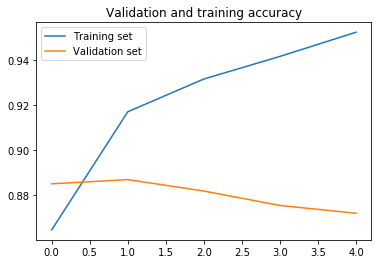

In [14]:
plt.plot(h_mlp.history['accuracy'], label="Training set")
plt.plot(h_mlp.history['val_accuracy'],label="Validation set")
plt.title('Validation and training accuracy')
plt.legend()
plt.show()

Dans cette partie, nous avons choisi de créer la matrice Tf-Idf avec comme vocabulaire les 5000 plus grand unigrammes afin de limiter le temps pour l'exécution de chaque époque. De plus, même en limitant le vocabulaire, le résultat du "val_accuracy" n'est pas affecté.
Pour l'optimiseur, nous avons choisi adam. En effet, nous avons les meilleurs résultats avec cet optimiseur. Aussi, cet optimiseur tend à donner la plus haute valeur de "val_accuracy" dès les premières époques. C'est pour cette raison que nous avons ajouté un callback EarlyStopping. Après 3 époques, si la valeur de "val_accuracy" ne s'est pas amélioré, notre modèle va s'arrêter.

### 3. Bi-directional LSTM

**b)** Toujours avec Keras, entraînez un modèle bi-LSTM sur le corpus d'entraînement. Comme précédemment, affichez la structure du réseau et indiquez les paramètres utiles.

*Note :* si votre machine supporte CUDA, vous pouvez utiliser `keras.layers.CuDNNLSTM` au lieu de `keras.layers.LSTM` pour des gains de performance significatifs. Sur Google Colab, les environnements avec GPU supportent CUDA.

In [15]:
LSTM_VOCABULARY_LEN = 5000
MAX_PADDING_SEQUENCE = 100

In [62]:
class DataGenerator(Sequence):
    def __init__(self, X, Y, batch_size=32, n_classes=LSTM_VOCABULARY_LEN):
        self.batch_size = batch_size
        self.Y = Y
        self.X = X
        self.n_classes = n_classes
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X_temp = [self.X[k] for k in indexes]
        
        Y = [self.Y[k] for k in indexes]
        X = self.__data_generation(X_temp)

        return X, Y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))

    def __data_generation(self, X_temp):
        return to_categorical(X_temp, num_classes=self.n_classes)

In [18]:
# Separer les donnees en donnees d'entrainement et de validation
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(train_corpus,
    Y, test_size=0.15)

# Convertir les textes en une matrice one hot
tokenizer = Tokenizer(num_words=LSTM_VOCABULARY_LEN)
tokenizer.fit_on_texts(train_corpus)
X_train_lstm = tokenizer.texts_to_sequences(X_train_lstm)
X_val_lstm = tokenizer.texts_to_sequences(X_val_lstm)
# padding pour obtenir meme largeur de chaque vecteur
X_train_lstm = sequence.pad_sequences(X_train_lstm, dtype=object, maxlen=MAX_PADDING_SEQUENCE)    
X_val_lstm = sequence.pad_sequences(X_val_lstm, dtype=object, maxlen=MAX_PADDING_SEQUENCE)
train_gen_lstm = DataGenerator(X_train_lstm, y_train_lstm)
val_gen_lstm = DataGenerator(X_val_lstm, y_val_lstm)

# Creer le modele LSTM
lstm_model = Sequential()
lstm_model.add(
    Bidirectional(
        LSTM(16),        
        input_shape = (MAX_PADDING_SEQUENCE, LSTM_VOCABULARY_LEN)
    )
)
lstm_model.add(
    Dense(1, activation="sigmoid")
)
lstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=['accuracy']
)

lstm_model.summary()

h_lstm = lstm_model.fit_generator(
    generator = train_gen_lstm, 
    epochs=20,
    validation_data=val_gen_lstm,
    use_multiprocessing=False,
    initial_epoch=0,
    callbacks=[earlyStoppingCallback]
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 32)                642176    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 642,209
Trainable params: 642,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
664/664 [==============================] - 119s 180ms/step - loss: 0.4480 - accuracy: 0.7837 - val_loss: 0.2924 - val_accuracy: 0.8507
Epoch 2/20
664/664 [==============================] - 120s 181ms/step - loss: 0.2879 - accuracy: 0.8787 - val_loss: 0.3561 - val_accuracy: 0.8341
Epoch 3/20
664/664 [==============================] - 119s 180ms/step - loss: 0.2361 - accuracy: 0.9040 - val_loss: 0.3306 - val_accuracy: 0.8499
Epoch 4/20
664/664 [==============================] - 120s 181ms/step - 

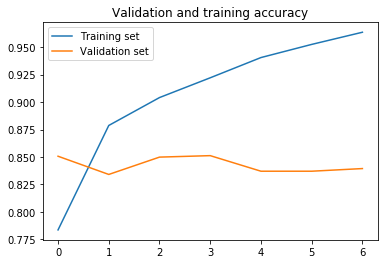

In [19]:
plt.plot(h_lstm.history['accuracy'], label="Training set")
plt.plot(h_lstm.history['val_accuracy'],label="Validation set")
plt.title('Validation and training accuracy')
plt.legend()
plt.show()

Dans cette partie, nous devons effectué une matrice one-hot. Par soucis d'économie de mémoire, nous avons décidé de limiter notre vocabulaire à 5000 mots. Aussi, encore par soucis d'économie de mémoire, la séquence dans le padding est limité à 100 mots. Comme ce fut le cas pour la partie MLP, limiter le vocabulaire est la séquence dans le padding n'affecte pas vraiment nos résultats de "val_accuracy". 

Pour l'optimiseur, encore une fois, nous avons choisi adam. En effet, nous avons les meilleurs résultats avec cet optimiseur. Comme pour la partie MLP, cet optimiseur tend à donner la plus haute valeur de "val_accuracy" dès les premières époques. C'est pour cette raison que nous avons ajouté un callback EarlyStopping. Après 3 époques, si la valeur de "val_accuracy" ne s'est pas amélioré, notre modèle va s'arrêter.

**c) Word Embeddings**

Pour améliorer le modèle précédent, on va utiliser des *word embeddings* (ou plongements vectoriels) pré-entraînés. 

On utilisera un modèle Skip-gram de dimension $d=300$ entraîné sur English Wikipedia, disponible à l'adresse [http://vectors.nlpl.eu/explore/embeddings/en/models/](http://vectors.nlpl.eu/explore/embeddings/en/models/). Dans cette archive, vous trouverez les embeddings dans un fichier `.txt` tel que 
- la première ligne du fichier indique le nombre de mots dans le vocabulaire et la dimension des embeddings
- chacune des lignes suivantes est composée d'un mot_étiquette grammaticale suivi des 300 coordonnées de son *embedding*, le tout séparé par des espaces. 

Ainsi, les premières lignes de ce fichier sont :
```
296630 300
also_ADV -0.010121 -0.045202 -0.065609 ... -0.065423
one_NUM -0.060427 0.005032 -0.076370 ... -0.107769
first_ADJ 0.005799 0.024848 0.018902 ...  -0.097193
...
```

Les étiquettes `_ADV`, `_NUM`, `_ADJ`, etc. indiquent l'étiquette grammaticale du mot et peuvent être supprimées pour ce TP.

*Note :* vous pouvez utiliser le snippet suivant pour télécharger et dézipper automatiquement les embeddings (pratique si vous utilisez une machine distante comme Google Colab) :
```python
import requests
import io
from zipfile import ZipFile

res = requests.get("http://link/to/archive.zip")
with ZipFile(io.BytesIO(res.content)) as z:
  z.extractall("extract/to/dir/")
```


Implémentez un modèle bi-LSTM qui utilisent ces *embeddings* pour représenter les mots d'une phrase. Vous pourrez utiliser le layer [Embedding](https://keras.io/layers/embeddings/) de Keras.

NOTE: J'ai modifie le fichier model.txt afin de retirer la premiere ligne 296630 300.

In [20]:
WIKI_VOCABULARY_LEN = 296630
DIMENSION = 300

In [21]:
# On lit le fichier model.txt
# On met dans un dictionnaire les vecteurs reliés à chaque mot

dictionnary_word2vec = {}
with open("./model.txt",'r', encoding="utf-8") as f:
    for line in f:
        word2vec = line.split()
        word = word2vec[0].split("_")[0]
        dictionnary_word2vec[word] = np.asarray(word2vec[1:], dtype = "float32")

In [22]:
def get_embedding_matrix(tokenizer_indexes):
    matrix_embedding = np.zeros((len(tokenizer_indexes) + 1, DIMENSION))
    
    for word, index in tokenizer_indexes.items():
        word2vec = dictionnary_word2vec.get(word)
        if word2vec is not None:
            matrix_embedding[index] = word2vec

    return matrix_embedding

In [26]:
# Separer les donnees en donnees d'entrainement et de validation
X_train_embedding, X_val_embedding, y_train_embedding, y_val_embedding = train_test_split(
    preprocessed_train_corpus, Y, test_size=0.15)

tokenizer.fit_on_texts(preprocessed_train_corpus)
tokenizer_indexes = tokenizer.word_index

X_train_embedding = tokenizer.texts_to_sequences(X_train_embedding)
X_val_embedding = tokenizer.texts_to_sequences(X_val_embedding)    

# padding pour obtenir meme largeur de chaque vecteur
X_train_embedding = sequence.pad_sequences(X_train_embedding, dtype=object, maxlen=MAX_PADDING_SEQUENCE)
X_val_embedding = sequence.pad_sequences(X_val_embedding, dtype=object, maxlen=MAX_PADDING_SEQUENCE)

# Creation matrice embedding
matrix_embedding = get_embedding_matrix(tokenizer_indexes)

# Create the LSTM model
lstm_model_embedding = Sequential()
lstm_model_embedding.add(
    Embedding(
        len(tokenizer_indexes) + 1,
        DIMENSION,
        input_length = MAX_PADDING_SEQUENCE,
        trainable=False,
        weights=[matrix_embedding]
    )
)

lstm_model_embedding.add(
    Bidirectional(
        LSTM(32),        
        input_shape = (MAX_PADDING_SEQUENCE, 32)
    )
)

lstm_model_embedding.add(Dense(1, activation="sigmoid"))

lstm_model_embedding.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=['accuracy']
)

lstm_model_embedding.summary()

h_embedding = lstm_model_embedding.fit(X_train_embedding, y_train_embedding,
        epochs=20,
        batch_size=128, 
        validation_data=[
            X_val_embedding,
            y_val_embedding],
        callbacks=[earlyStoppingCallback]
)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          27367800  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                85248     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 27,453,113
Trainable params: 85,313
Non-trainable params: 27,367,800
_________________________________________________________________
Train on 21250 samples, validate on 3750 samples
Epoch 1/20
21250/21250 [==============================] - 21s 998us/step - loss: 0.5487 - accuracy: 0.7267 - val_loss: 0.4931 - val_accuracy: 0.7528
Epoch 2/20
21250/21250 [==============================] - 21s 971us/step - loss: 0.4431 - accuracy: 0.8001 - val_loss: 0.4227 - val_accuracy: 0.7957
Epoch 3/20
21250/212

### 5. Évaluation

**d)** Indiquez les performances de chacun de vos modèles. Comparez avec les modèles Naive Bayes et character-LM du TP précédent et commentez.

Quel est votre meilleur modèle ?

In [27]:
test_corpus = data[DATA_TEST_POS] + data[DATA_TEST_NEG]
preprocessed_test_corpus = preprocessed_data[DATA_TEST_POS] + preprocessed_data[DATA_TEST_NEG]

Y_test = np.concatenate((np.ones(len(data[DATA_TEST_POS])), np.zeros(len(data[DATA_TEST_NEG]))))

In [28]:
# Evaluate MLP
X_test_MLP = vectorizer.transform(test_corpus)
evaluate_mlp = mlp_model.evaluate(X_test_MLP, Y_test)

25000/25000 [==============================] - 2s 64us/step


In [31]:
print("Pour le modèle MLP")
print("La valeur de loss: " + str(evaluate_mlp[0]))
print("La valeur de accuracy: " + str(evaluate_mlp[1]))

Pour le modèle MLP
La valeur de loss: 0.11113903087198734
La valeur de accuracy: 0.8565599918365479


In [ ]:
print(len(test_corpus))

In [63]:
# Evaluate Bi-LSTM
tokenizer.fit_on_texts(test_corpus)
X_test_LSTM = tokenizer.texts_to_sequences(test_corpus)
X_test_LSTM = sequence.pad_sequences(X_test_LSTM, dtype=object, maxlen = MAX_PADDING_SEQUENCE)
test_gen_lstm = DataGenerator(X_test_LSTM, Y_test)

evaluate_LSTM = lstm_model.evaluate_generator(
    generator = test_gen_lstm,
    use_multiprocessing=False,
    workers=1,
    verbose=1
)

781/781 [==============================] - 82s 104ms/step


In [64]:
print("Pour le modèle Bi-directional LSTM")
print("La valeur de loss: " + str(evaluate_LSTM[0]))
print("La valeur de accuracy: " + str(evaluate_LSTM[1]))

Pour le modèle Bi-directional LSTM
La valeur de loss: 1.3840802907943726
La valeur de accuracy: 0.5154449343681335


In [44]:
# Evaluate Bi-LSTM avec embedding
X_test_embedding = tokenizer.texts_to_sequences(preprocessed_test_corpus)
X_test_embedding = sequence.pad_sequences(X_test_embedding, dtype=object, maxlen = MAX_PADDING_SEQUENCE)
evaluate_LSTM_emdedding = lstm_model_embedding.evaluate(X_test_embedding, Y_test)

25000/25000 [==============================] - 42s 2ms/step


In [45]:
print("Pour le modèle Bi-directional LSTM avec embedding")
print("La valeur de loss: " + str(evaluate_LSTM_emdedding[0]))
print("La valeur de accuracy: " + str(evaluate_LSTM_emdedding[1]))

Pour le modèle Bi-directional LSTM avec embedding
La valeur de loss: 0.4977879947400093
La valeur de accuracy: 0.7587199807167053


Les word embeddings permettent d'améliorer le résultat du modèle Bi-directional LSTM. Par contre, nous avons essayé de construire notre matrice des word embeddings basé sur le corpus et non la base de données de Wikipedia. Lorsque nous avons fait ce test, on obtenait un validation accuracy d'environ 90%, ce qui est encore plus performant que nos résultats actuels. 

Le modèle MLP est celui dont la durée d'entrainement est le plus rapide. Vu que notre modèle Bi-directional LSTM a beaucoup plus de données, il est normal qu'il soit beaucoup plus long à entrainer.  

Dans le TP précédent, on avait comme meilleur modèle le modèle BOW_Naive. Son accuracy était de 0.87. Si l'on compare, avec chacun des trois modèles de ce laboratoire, il est le plus performant. 

Plusieurs paramètres peuvent expliquer ce résultat. En effet, ce qui nous est demandé n'est pas très complexe. En effet, Naive Bayes utilise un modèle de sac de mots (bag of words) pour représenter les différents reviews. Par conséquent, si le modèle voit des mots du genre "bad", il va conclure que c'est un review négatif.
Les trois modèles de ce laboratoire nécessitent de voir la connexion entre chaque mot.

De plus, il aurait pu être intéressant de jouer avec les hyperparamètres des différents modèles.